In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
%%capture
!pip install netcdf4
!pip install geopandas

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
import matplotlib.colors as colors
import seaborn as sns
import glob as glb

In [4]:
%cd /content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos

/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos


In [5]:
files = sorted(glb.glob("*dat"))
files

['starnet_2015-01.dat',
 'starnet_2015-02.dat',
 'starnet_2015-03.dat',
 'starnet_2015-04.dat',
 'starnet_2015-05.dat',
 'starnet_2015-06.dat',
 'starnet_2015-07.dat',
 'starnet_2015-08.dat',
 'starnet_2015-09.dat',
 'starnet_2015-10.dat',
 'starnet_2015-11.dat',
 'starnet_2015-12.dat',
 'starnet_2016-01.dat',
 'starnet_2016-02.dat',
 'starnet_2016-03.dat',
 'starnet_2016-04.dat',
 'starnet_2016-05.dat',
 'starnet_2016-06.dat',
 'starnet_2016-07.dat',
 'starnet_2016-08.dat',
 'starnet_2016-09.dat',
 'starnet_2016-10.dat',
 'starnet_2016-11.dat',
 'starnet_2016-12.dat',
 'starnet_2017-01.dat',
 'starnet_2017-02.dat',
 'starnet_2017-03.dat',
 'starnet_2017-04.dat',
 'starnet_2017-05.dat',
 'starnet_2017-06.dat',
 'starnet_2017-07.dat',
 'starnet_2017-08.dat',
 'starnet_2017-09.dat',
 'starnet_2017-10.dat',
 'starnet_2017-11.dat']

In [6]:
archivos=[]
for file in files:
   leer=pd.read_table(file, sep="\s+",header=None)
   leer.rename(columns={0:"year",1:"month",2:"day",3:"hour",4:"minute",
                        5:"second",7:"Y",8:"X",11:"Control",
                        12:"Polaridad"}, inplace=True )
   columnas=["year","month","day","hour","minute","second","Y","X",
             "Control","Polaridad"]
   df = leer[columnas]
   df = df[(df["Y"]>= -12.75)& (df["Y"]<= -10.65)]
   df = df[(df["X"]>= -76.6)& (df["X"]<= -73.25)]
   df = df[df["Control"]==0]
   df = df[(df["Polaridad"]== -3) | (df["Polaridad"]== 3)]
   archivos.append(df)
archivos

[      year  month  day  hour  minute  second         Y         X  Control  \
 7     2015      1    1    18      42      41 -10.75407 -76.43712        0   
 9     2015      1    1    18      52      24 -11.76677 -76.17023        0   
 10    2015      1    1    18      54      29 -11.55424 -76.55527        0   
 45    2015      1    1    20      30      30 -11.15978 -76.58412        0   
 56    2015      1    1    20      36      50 -11.22763 -76.31982        0   
 ...    ...    ...  ...   ...     ...     ...       ...       ...      ...   
 4153  2015      1   31    19      55      43 -11.65784 -76.03418        0   
 4155  2015      1   31    20      16      34 -10.65026 -76.40933        0   
 4160  2015      1   31    20      44      49 -10.71354 -76.36227        0   
 4163  2015      1   31    20       6      48 -11.65980 -76.05984        0   
 4171  2015      1   31    22      40      32 -11.39097 -75.44962        0   
 
       Polaridad  
 7            -3  
 9             3  
 10  

In [7]:
combinaciones = []

# Realizar las combinaciones de los primeros 4 archivos
for i in range(0, 34, 2):
    comb = pd.merge(archivos[i], archivos[i+1], how="outer")
    combinaciones.append(comb)

# Realizar las combinaciones de las combinaciones anteriores
while len(combinaciones) > 1:
    new_combinaciones = []
    for i in range(0, len(combinaciones), 2):
        if i+1 < len(combinaciones):
            comb = pd.merge(combinaciones[i], combinaciones[i+1], how="outer")
            new_combinaciones.append(comb)
        else:
            # Agregar la combinación sin pareja (si hay un número impar de combinaciones)
            new_combinaciones.append(combinaciones[i])
    combinaciones = new_combinaciones

resultado_final = combinaciones[0]

In [8]:
df_clim = pd.merge(resultado_final,archivos[34],how="outer")
df_clim.tail()

,year,month,day,hour,minute,second,Y,X,Control,Polaridad
15721,2017,11,30,22,39,46,-10.81168,-75.70582,0,-3
15722,2017,11,30,0,58,9,-11.86570,-75.39438,0,-3
15723,2017,11,30,1,25,54,-11.98060,-75.28843,0,-3
15724,2017,11,30,1,25,55,-11.90751,-75.29478,0,-3
15725,2017,11,30,1,9,51,-11.81294,-75.44318,0,-3


In [9]:
meses = ["enero", "febrero", "marzo","abril","mayo","junio","julio","agosto",
         "septiembre","octubre","noviembre","diciembre"]
df_por_mes = {}
for mes_numero, mes_nombre in enumerate(meses, start=1):
    df_por_mes[mes_nombre] = df_clim[df_clim["month"] == mes_numero]

In [10]:
# Guardar cada mes en una variable separada
for mes_nombre, df_por_mes in df_por_mes.items():
    globals()["df_" + mes_nombre] = df_por_mes

In [11]:
schema = {
    'geometry':'Point',
    'properties':[('year','int'),('month','int'),('day','int'),('hour','int'),
     ('minute','int'),('second','int'),("Control","int"),("Polaridad","int")]
}

In [12]:
pointShp1 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_enero.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")

In [13]:
for index, row in df_enero.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp1.write(rowDict)
pointShp1.close()

In [14]:
#para enero
pointShp1 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_enero.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_enero.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp1.write(rowDict)
pointShp1.close()
#para febrero
pointShp2 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_febrero.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_febrero.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp2.write(rowDict)
pointShp2.close()
#para marzo
pointShp3 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_marzo.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_marzo.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp3.write(rowDict)
pointShp3.close()
#para abril
pointShp4 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_abril.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_abril.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp4.write(rowDict)
pointShp4.close()
#para mayo
pointShp5 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_mayo.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_mayo.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp5.write(rowDict)
pointShp5.close()
#para junio
pointShp6 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_junio.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_junio.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp6.write(rowDict)
pointShp6.close()
#para julio
pointShp7 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_julio.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_julio.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp7.write(rowDict)
pointShp7.close()
#para agosto
pointShp8 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_agosto.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_agosto.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp8.write(rowDict)
pointShp8.close()
#para septiembre
pointShp9 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_septiembre.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_septiembre.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp9.write(rowDict)
pointShp9.close()
#para octubre
pointShp10 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_octubre.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_octubre.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp10.write(rowDict)
pointShp10.close()
#para noviembre
pointShp11 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_noviembre.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_noviembre.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp11.write(rowDict)
pointShp11.close()
#para diciembre
pointShp12 = fiona.open('/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_diciembre.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")
for index, row in df_diciembre.iterrows():
    rowDict = {
        'geometry' : {'type':'Point',
                     'coordinates': (row.X,row.Y)},
        'properties': {"year" : row.year, "month": row.month,"day":row.day,
                       "hour":row.hour,"minute":row.minute,"second":row.second,
                       "Control":row.Control,"Polaridad":row.Polaridad},
    }
    pointShp12.write(rowDict)
pointShp12.close()

In [15]:
#shapefile enero
ruta_enero = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_enero.shp"
shape_enero = gpd.read_file(ruta_enero)
#shapefile febrero
ruta_feb = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_febrero.shp"
shape_feb = gpd.read_file(ruta_feb)
#shapefile marzo
ruta_marzo = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_marzo.shp"
shape_marzo = gpd.read_file(ruta_marzo)
#shapefile abril
ruta_abril = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_abril.shp"
shape_abril = gpd.read_file(ruta_abril)
#shapefile mayo
ruta_mayo = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_mayo.shp"
shape_mayo = gpd.read_file(ruta_mayo)
#shapefile junio
ruta_junio = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_junio.shp"
shape_junio = gpd.read_file(ruta_junio)
#shapefile julio
ruta_julio = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_julio.shp"
shape_julio = gpd.read_file(ruta_julio)
#shapefile agosto
ruta_agosto = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_agosto.shp"
shape_agosto = gpd.read_file(ruta_agosto)
#shapefile septiembre
ruta_sep = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_septiembre.shp"
shape_sep = gpd.read_file(ruta_sep)
#shapefile octubre
ruta_oct = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_octubre.shp"
shape_oct = gpd.read_file(ruta_oct)
#shapefile noviembre
ruta_nov = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_noviembre.shp"
shape_nov = gpd.read_file(ruta_nov)
#shapefile diciembre
ruta_dic = "/content/MyDrive/MyDrive/2023-1/3. Meteo fisica/Datos-rayos/Incidencia/rayos_diciembre.shp"
shape_dic = gpd.read_file(ruta_dic)

In [16]:
ruta_provincias = "/content/MyDrive/MyDrive/SIG/LIMITES/PROVINCIAS_inei_geogpsperu_suyopomalia.shp"
provincias = gpd.read_file(ruta_provincias)
Junin = provincias[provincias["NOMBDEP"]=="JUNIN"]
ruta_distritos = "/content/MyDrive/MyDrive/SIG/LIMITES/DISTRITOS_inei_geogpsperu_suyopomalia.shp"
distritos = gpd.read_file(ruta_distritos)
distritos_clip = distritos.clip(Junin)

(-12.75, -10.65)

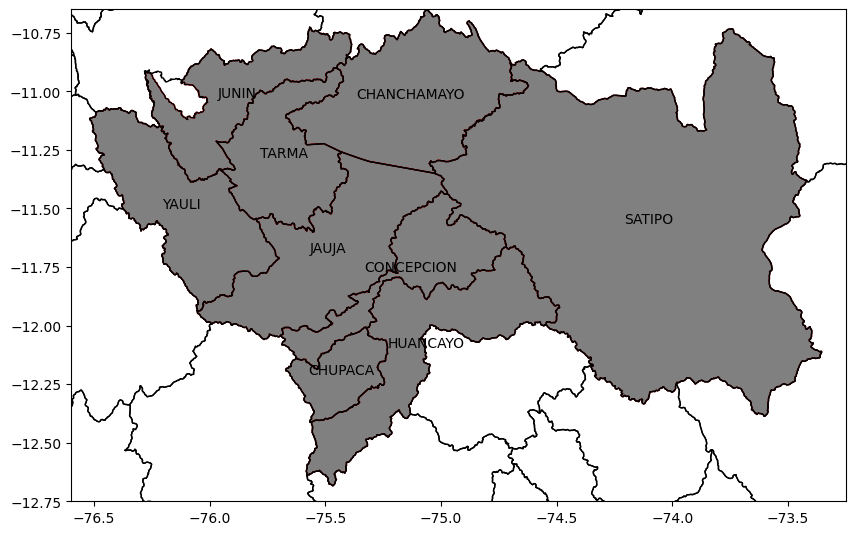

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = Junin.plot(ax=ax,facecolor="gray",edgecolor="red")
Junin.apply(lambda x: ax.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax,facecolor="none",edgecolor="black")
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

(-12.75, -10.65)

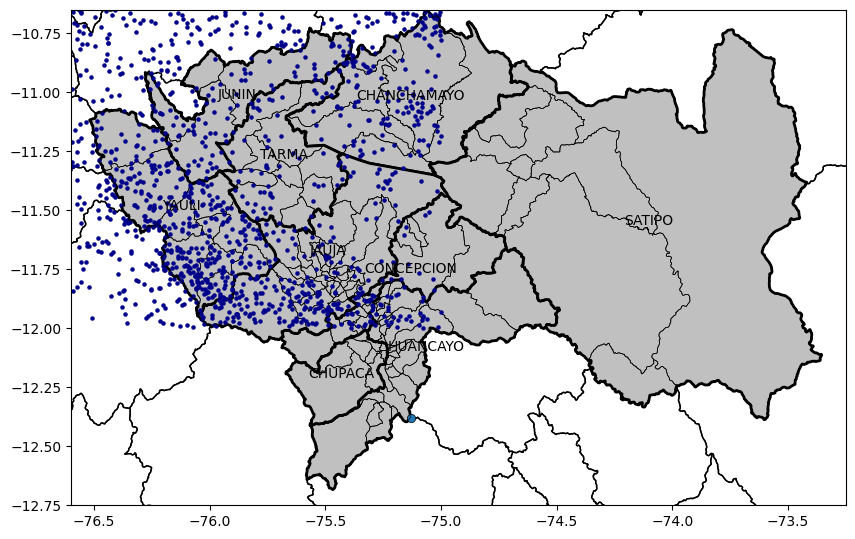

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = Junin.plot(ax=ax,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_enero.plot(ax=ax,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Mapa de todos los meses

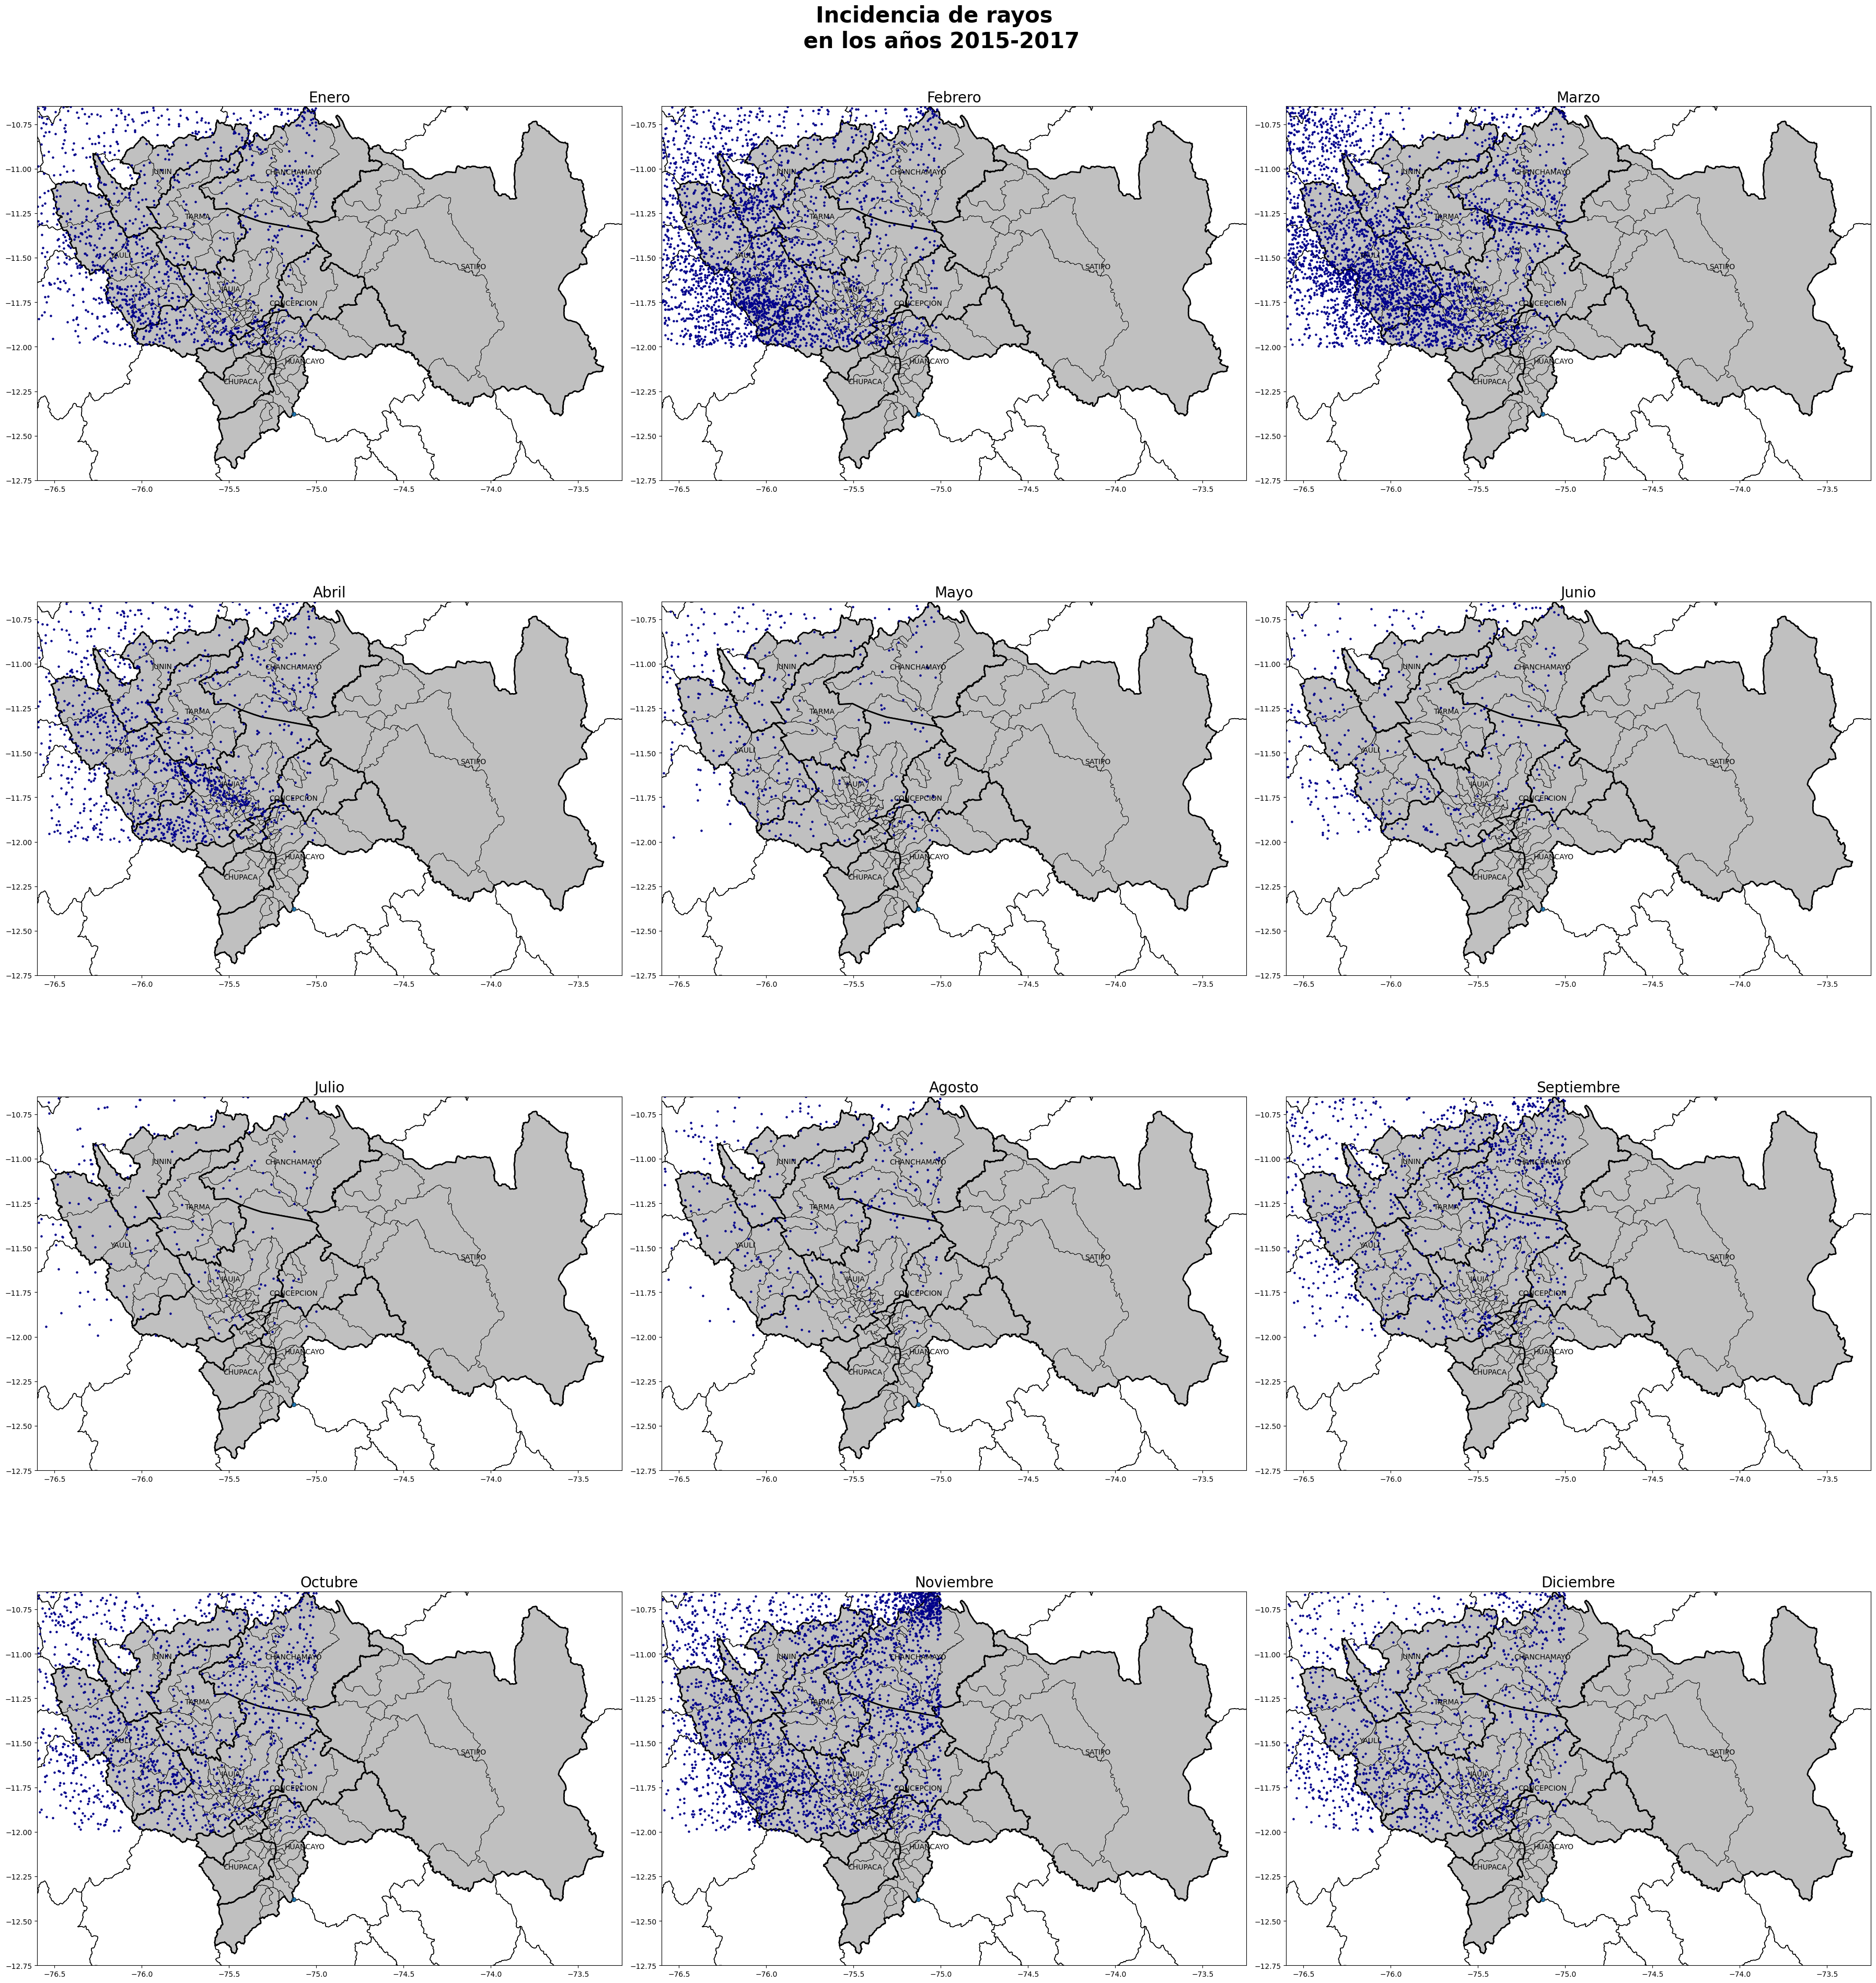

In [22]:
fig, axs = plt.subplots(4, 3, figsize=(36, 40))
from mpl_toolkits.mplot3d import axes3d
fig.suptitle("Incidencia de rayos \n en los años 2015-2017",fontsize=30,fontweight="bold")
#para enero
ax1 = axs[0,0]
Junin.plot(ax=ax1,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax1.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax1,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax1,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_enero.plot(ax=ax1,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax1.set_xlim(minx, maxx)
ax1.set_ylim(miny, maxy)
ax1.set_title("Enero", fontsize=20)

#para febrero
ax2 = axs[0,1]
Junin.plot(ax=ax2,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax2.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax2,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax2,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_feb.plot(ax=ax2,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
ax2.set_title("Febrero", fontsize=20)

#para marzo
ax3 = axs[0,2]
Junin.plot(ax=ax3,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax3.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax3,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax3,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_marzo.plot(ax=ax3,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax3.set_xlim(minx, maxx)
ax3.set_ylim(miny, maxy)
ax3.set_title("Marzo", fontsize=20)

#para abril
ax4 = axs[1,0]
Junin.plot(ax=ax4,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax4.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax4,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax4,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_abril.plot(ax=ax4,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax4.set_xlim(minx, maxx)
ax4.set_ylim(miny, maxy)
ax4.set_title("Abril", fontsize=20)

#para mayo
ax5 = axs[1,1]
Junin.plot(ax=ax5,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax5.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax5,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax5,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_mayo.plot(ax=ax5,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax5.set_xlim(minx, maxx)
ax5.set_ylim(miny, maxy)
ax5.set_title("Mayo", fontsize=20)

#para junio
ax6 = axs[1,2]
Junin.plot(ax=ax6,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax6.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax6,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax6,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_junio.plot(ax=ax6,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax6.set_xlim(minx, maxx)
ax6.set_ylim(miny, maxy)
ax6.set_title("Junio", fontsize=20)

#para julio
ax7 = axs[2,0]
Junin.plot(ax=ax7,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax7.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax7,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax7,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_julio.plot(ax=ax7,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax7.set_xlim(minx, maxx)
ax7.set_ylim(miny, maxy)
ax7.set_title("Julio", fontsize=20)

#para agosto
ax8 = axs[2,1]
Junin.plot(ax=ax8,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax8.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax8,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax8,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_agosto.plot(ax=ax8,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax8.set_xlim(minx, maxx)
ax8.set_ylim(miny, maxy)
ax8.set_title("Agosto", fontsize=20)

#para septiembre
ax9 = axs[2,2]
Junin.plot(ax=ax9,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax9.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax9,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax9,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_sep.plot(ax=ax9,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax9.set_xlim(minx, maxx)
ax9.set_ylim(miny, maxy)
ax9.set_title("Septiembre", fontsize=20)

#para octubre
ax10 = axs[3,0]
Junin.plot(ax=ax10,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax10.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax10,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax10,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_oct.plot(ax=ax10,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax10.set_xlim(minx, maxx)
ax10.set_ylim(miny, maxy)
ax10.set_title("Octubre", fontsize=20)

#para noviembre
ax11 = axs[3,1]
Junin.plot(ax=ax11,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax11.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax11,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax11,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_nov.plot(ax=ax11,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax11.set_xlim(minx, maxx)
ax11.set_ylim(miny, maxy)
ax11.set_title("Noviembre", fontsize=20)

#para diciembre
ax12 = axs[3,2]
Junin.plot(ax=ax12,facecolor="silver",edgecolor="black",linewidth=2)
Junin.apply(lambda x: ax12.annotate(text=x['NOMBPROV'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
lugar = provincias.plot(ax=ax12,facecolor="none",edgecolor="black")
dist = distritos_clip.plot(ax=ax12,facecolor="none",edgecolor="black",linewidth=0.5)
estaciones = shape_dic.plot(ax=ax12,color="darkblue",marker="o",markersize=5)
minx, miny, maxx, maxy = -76.6, -12.75, -73.25, -10.65
ax12.set_xlim(minx, maxx)
ax12.set_ylim(miny, maxy)
ax12.set_title("Diciembre", fontsize=20)

plt.tight_layout()

# Seleccion del area de estudios
Vemos que hay mayor incidencia de rayos en las provincias de Junin, Yaullli, Tarma, Chanchamayo, Jauja y Concepción. Cabe mencionar que estas incidencias disminuyen en los meses de inviernos. Elegiremos la provincia de Jauja y haremos enfasis en el distrito en donde ocurre màs.

In [ ]:
distritos_clip

,UBIGEO,OBJECTID,NOMBDEP,NOMBPROV,NOMBDIST,CAPITAL,POBTOTAL,POB_EDAD_T,POB_EDAD_E,DENSIDAD,...,MUJERES__3,HOMBRES_NA,HOMBRES__2,TOTAL_NACI,IND_121951,IND_122042,IND_122047,IND_516462,IND_516484,geometry
485,080907,486.0,CUSCO,LA CONVENCION,KIMBIRI,KIMBIRI,18722.0,12949.0,11036.0,20.671532,...,290.0,47.935368,267.0,557.0,168.0,77814.03920,73085.74736,1400000.00,1663.0,"MULTILINESTRING ((-73.64351 -12.37308, -73.642..."
486,080910,487.0,CUSCO,LA CONVENCION,PICHARI,PICHARI,25366.0,17588.0,15214.0,34.726538,...,380.0,50.456323,387.0,767.0,857.0,98561.93907,94293.42729,1140000.00,3397.0,"MULTILINESTRING ((-73.98045 -12.24259, -73.978..."
497,050409,498.0,AYACUCHO,HUANTA,CANAYRE,CANAYRE,3938.0,2652.0,2397.0,16.093833,...,0.0,0.000000,0.0,0.0,22.0,8009.32748,13904.28303,210750.00,386.0,"MULTILINESTRING ((-74.18735 -12.30664, -74.187..."
1843,050411,1844.0,AYACUCHO,HUANTA,PUCACOLPA,HUALLHUA,2692.0,1710.0,1298.0,4.642340,...,0.0,0.000000,0.0,0.0,34.0,5180.65537,4216.15094,36000.00,714.0,"MULTILINESTRING ((-74.34843 -12.17503, -74.350..."
1846,120609,1847.0,JUNIN,SATIPO,VIZCATAN DEL ENE,SAN MIGUEL DEL ENE,4765.0,3384.0,3097.0,7.548993,...,24.0,31.428571,11.0,35.0,25.0,3303.03329,2514.88382,39996.16,154.0,"POLYGON ((-74.08078 -12.13209, -74.07982 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,190105,714.0,PASCO,PASCO,NINACACA,NINACACA,4111.0,2951.0,2411.0,8.077890,...,41.0,52.325581,45.0,86.0,31.0,4503.13465,3631.41147,135255.00,424.0,"MULTILINESTRING ((-75.99329 -10.82084, -75.993..."
708,120504,709.0,JUNIN,JUNIN,ULCUMAYO,ULCUMAYO,4425.0,3240.0,2558.0,3.918114,...,61.0,44.036697,48.0,109.0,38.0,4772.27909,3330.37048,39360.00,868.0,"POLYGON ((-75.53136 -10.74333, -75.53125 -10.7..."
748,190107,749.0,PASCO,PASCO,PAUCARTAMBO,PAUCARTAMBO,11637.0,8675.0,7283.0,14.877459,...,118.0,53.543307,136.0,254.0,107.0,21759.42496,31458.25959,260000.00,1702.0,"MULTILINESTRING ((-75.53142 -10.74330, -75.531..."
662,190301,663.0,PASCO,OXAPAMPA,OXAPAMPA,OXAPAMPA,16565.0,12618.0,10658.0,39.454567,...,100.0,55.156951,123.0,223.0,281.0,20621.30634,24998.47473,335000.00,706.0,"MULTILINESTRING ((-75.31047 -10.82775, -75.311..."


In [ ]:
Jauja = Junin[Junin["NOMBPROV"]=="JAUJA"]
distritos_Jauja = distritos.clip(Jauja)

(-12.25, -11.0)

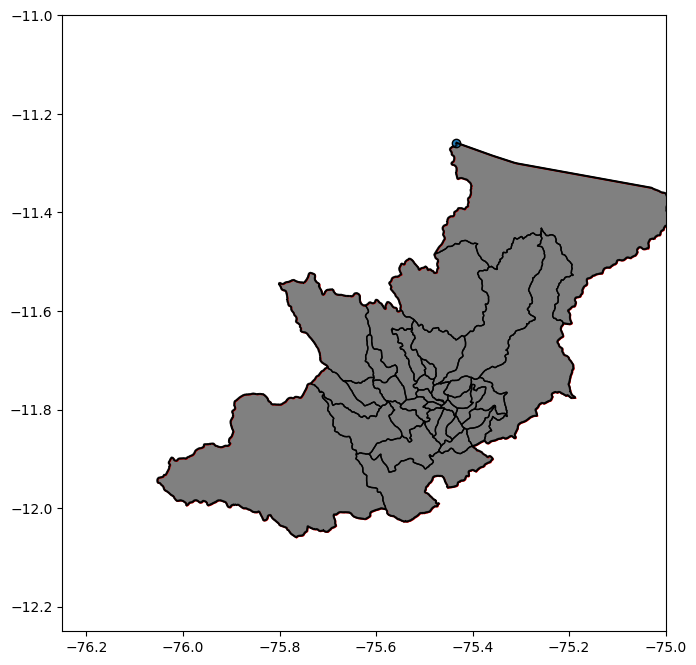

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = Jauja.plot(ax=ax,facecolor="gray",edgecolor="red")
lugar = distritos_Jauja.plot(ax=ax,facecolor="none",edgecolor="black")
minx, miny, maxx, maxy = -76.25, -12.25, -75, -11
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [ ]:
canchayllo = distritos_Jauja[distritos_Jauja["NOMBDIST"]=="CANCHAYLLO"]
canchayllo

,UBIGEO,OBJECTID,NOMBDEP,NOMBPROV,NOMBDIST,CAPITAL,POBTOTAL,POB_EDAD_T,POB_EDAD_E,DENSIDAD,...,MUJERES__3,HOMBRES_NA,HOMBRES__2,TOTAL_NACI,IND_121951,IND_122042,IND_122047,IND_516462,IND_516484,geometry
1248,120405,1249.0,JUNIN,JAUJA,CANCHAYLLO,CANCHAYLLO,1700.0,1259.0,1029.0,1.744144,...,5.0,80.0,20.0,25.0,12.0,1228.16281,993.66188,33000.0,188.0,"POLYGON ((-75.70845 -11.77042, -75.70970 -11.7..."


In [ ]:
canchayllo.to_csv("canchayllo.csv")

(-12.125, -11.625)

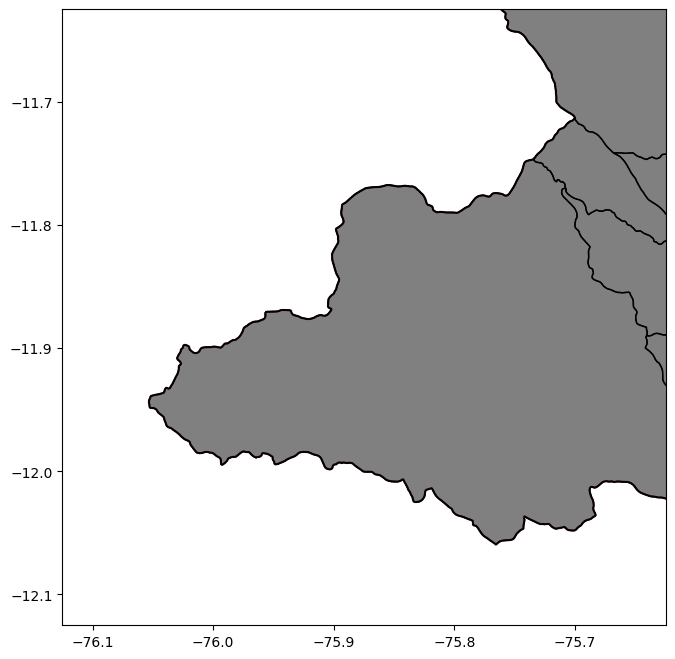

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = Jauja.plot(ax=ax,facecolor="gray",edgecolor="red")
lugar = distritos_Jauja.plot(ax=ax,facecolor="none",edgecolor="black")
minx, miny, maxx, maxy = -76.125, -12.125, -75.625, -11.625
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

El cuadrante elegido seria de:
- Latitud: -12.125,-11.625
- Longitud: -76.125,-75.625